In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir)[:500] if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir)[:500] if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/crash_data/crashed'
non_crash_dir ='/home/baklava/crash_data/nocrashed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Compute lengths for each split
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_length, val_length, test_length])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


In [2]:
dataset[20][0].shape

/tmp/ipykernel_2334723/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


torch.Size([3, 16, 224, 224])

/tmp/ipykernel_2334723/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


Sequence Label: 1
Frames Shape: torch.Size([3, 16, 224, 224])


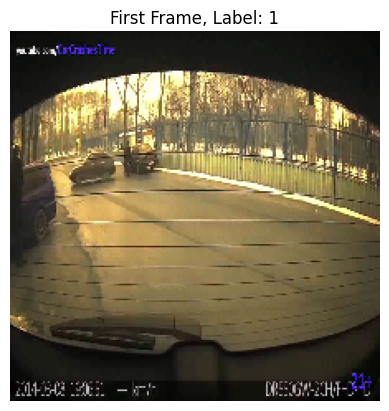

In [3]:
# Get the first item from the dataset
frames, label = dataset[0]

# Print label
print("Sequence Label:", label)  # 0 or 1

# Print the shape of the frames
print("Frames Shape:", frames.shape)  # [C, T, H, W]

# Inspect the first frame in the sequence
first_frame = frames[:, 15, :, :]  # Extract the first frame (shape: [C, H, W])

# Convert the first frame to a numpy array for visualization
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Denormalize the image for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
denormalized_frame = first_frame * std + mean  # Reverse normalization

# Convert to numpy for display
frame_np = denormalized_frame.permute(1, 2, 0).numpy()  # [H, W, C]

# Plot the frame
plt.imshow(frame_np)
plt.title(f"First Frame, Label: {label}")
plt.axis('off')
plt.show()


In [4]:
import torch
import torch.nn as nn
from torchvision.models.video import swin3d_b

class VideoSwinCrashPredictor(nn.Module):
    def __init__(self, num_classes=1):
        super(VideoSwinCrashPredictor, self).__init__()
        # Load pretrained Video Swin Transformer
        self.swin3d = swin3d_b(pretrained=True)
        
        # Replace the classification head to match our binary task
        self.swin3d.head = nn.Sequential(
            nn.Linear(self.swin3d.head.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Binary output
        )

    def forward(self, x):
        """
        x: Video Tensor of shape [B, C, T, H, W]
           B: Batch size
           C: Number of channels (e.g., 3 for RGB)
           T: Number of frames
           H, W: Height and width of each frame
        """
        return self.swin3d(x)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    model = VideoSwinCrashPredictor()
    
    # Dummy input: batch of 4 videos, each with 16 frames of size 224x224
    video_input = torch.randn(4, 3, 16, 224, 224)
    
    # Forward pass
    output = model(video_input)
    print("Output shape:", output.shape)  # Expected: [4, 1]


/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin3D_B_Weights.KINETICS400_V1`. You can also use `weights=Swin3D_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([4, 1])


In [5]:
# Initialize history dictionary
# Define loss function and optimizer
from tqdm import tqdm
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history = {
    "train_loss": [],
    "val_loss": [],
    "test_loss": 0.0,
    "test_accuracy": 0.0
}
device ='cuda'

# Training and validation loop
num_epochs = 5
model=model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1} - Training") as pbar:
        for video_batch, labels in train_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            
            loss = criterion(outputs, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)
    
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1} - Validation") as pbar:
            for video_batch, labels in val_loader:
                video_batch = video_batch.to(device)
                labels = labels.to(device)
                outputs = model(video_batch).squeeze()
            
            # Reshape outputs to match labels
                outputs = outputs.view_as(labels)
                
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
    
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

history["test_loss"] = test_loss / len(test_loader)
history["test_accuracy"] = correct_predictions / total_predictions
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")


Epoch 1 - Training:   0%|          | 0/175 [00:00<?, ?it/s]/tmp/ipykernel_2334723/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Epoch 1 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.21s/it, Batch Loss=0.691]


Epoch 1, Training Loss: 0.6814


Epoch 1 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.34it/s, Batch Loss=0.601]


Epoch 1, Validation Loss: 0.6587


Epoch 2 - Training: 100%|██████████| 175/175 [03:33<00:00,  1.22s/it, Batch Loss=0.503]


Epoch 2, Training Loss: 0.6051


Epoch 2 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.29it/s, Batch Loss=0.407]


Epoch 2, Validation Loss: 0.5261


Epoch 3 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.22s/it, Batch Loss=0.19] 


Epoch 3, Training Loss: 0.4057


Epoch 3 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.33it/s, Batch Loss=0.176]


Epoch 3, Validation Loss: 0.2526


Epoch 4 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.21s/it, Batch Loss=0.137] 


Epoch 4, Training Loss: 0.1748


Epoch 4 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.34it/s, Batch Loss=0.0667]


Epoch 4, Validation Loss: 0.0978


Epoch 5 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.21s/it, Batch Loss=0.106] 


Epoch 5, Training Loss: 0.0880


Epoch 5 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.33it/s, Batch Loss=0.0325]


Epoch 5, Validation Loss: 0.0500


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]

Test Loss: 0.0776, Test Accuracy: 97.00%


In [98]:
import json

# Save to a file
with open("training_history.json", "w") as f:
    json.dump(history, f)

# Load the history later
with open("training_history.json", "r") as f:
    loaded_history = json.load(f)

In [99]:
loaded_history

{'train_loss': [0.5859538238389151],
 'val_loss': [0.5068558505177498],
 'test_loss': 0.5133870479464531,
 'test_accuracy': 0.94}

In [ ]:
# torch.save(model, 'crash_predector_model.pth')  # Saves the entire model including the architecture


In [101]:
model

VideoSwinCrashPredictor(
  (swin3d): SwinTransformer3d(
    (patch_embed): PatchEmbed3d(
      (proj): Conv3d(3, 128, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (features): Sequential(
      (0): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention3d(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=512, out

In [2]:
import torch

In [3]:
model = torch.load('crash_predector_model.pth')

/tmp/ipykernel_2588959/2045320317.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('crash_predector_model.pth')


AttributeError: Can't get attribute 'VideoSwinCrashPredictor' on <module '__main__'>

Testing:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2334723/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Testing: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Test Loss: 0.0776, Test Accuracy: 97.00%
Test Precision: 0.9574
Test Recall: 0.9783
Test F1 Score: 0.9677
Confusion Matrix:
[[52  2]
 [ 1 45]]


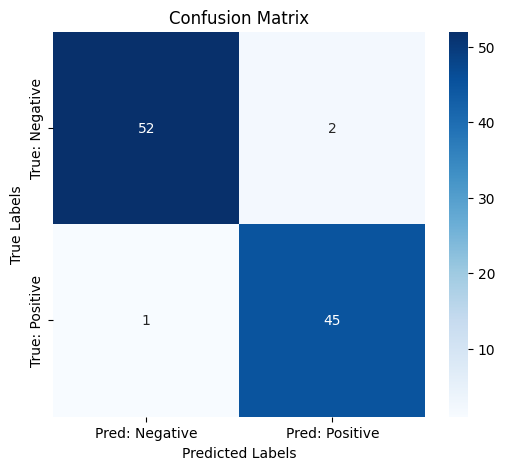

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            # Collecting predictions and true labels for F1, precision, recall, and confusion matrix
            predictions = (outputs > 0.5).float()
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

# Calculate the average test loss
history["test_loss"] = test_loss / len(test_loader)

# Calculate accuracy
history["test_accuracy"] = correct_predictions / total_predictions

# Flatten the list of labels and predictions for F1, precision, recall, and confusion matrix
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

history["test_precision"] = precision
history["test_recall"] = recall
history["test_f1"] = f1
history["test_confusion_matrix"] = conf_matrix

# Print results
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Negative", "Pred: Positive"], yticklabels=["True: Negative", "True: Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [36]:
model.eval()
video_batch,labels=dataset[600]
# print(video_batch)
video_batch = video_batch.to(device)
video_batch=video_batch.unsqueeze(0)
# labels = labels.to(device)

# outputs = model([video_batch]).squeeze()
outputs = model(video_batch).squeeze()
predictions =int((outputs > 0.5))
# outputs = outputs.view_as(labels)
print(predictions,labels)

0 0


/tmp/ipykernel_1849282/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


In [104]:
!pip install seaborn

In [12]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18

class VideoR3DCrashPredictor(nn.Module):
    def __init__(self, num_classes=1):
        super(VideoR3DCrashPredictor, self).__init__()
        # Load pretrained R3D model
        self.r3d = r3d_18(pretrained=True)  # ResNet-3D with 18 layers
        
        # Replace the classification head to match our binary task
        self.r3d.fc = nn.Sequential(
            nn.Linear(self.r3d.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Binary output
        )

    def forward(self, x):
        """
        x: Video Tensor of shape [B, C, T, H, W]
           B: Batch size
           C: Number of channels (e.g., 3 for RGB)
           T: Number of frames
           H, W: Height and width of each frame
        """
        return self.r3d(x)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    model = VideoR3DCrashPredictor()
    
    # Dummy input: batch of 4 videos, each with 16 frames of size 112x112
    # video_input = torch.randn(4, 3, 16, 112, 112)  # R3D typically uses 112x112 frame size
    
    # # Forward pass
    # output = model(video_input)
    # print("Output shape:", output.shape)  # Expected: [4, 1]


/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir)[:500] if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir)[:500] if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/crash_data/crashed'
non_crash_dir ='/home/baklava/crash_data/nocrashed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Compute lengths for each split
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_length, val_length, test_length])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


In [14]:
# Initialize history dictionary
# Define loss function and optimizer
from tqdm import tqdm
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history = {
    "train_loss": [],
    "val_loss": [],
    "test_loss": 0.0,
    "test_accuracy": 0.0
}
device ='cuda'

# Training and validation loop
num_epochs = 5
model=model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1} - Training") as pbar:
        for video_batch, labels in train_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            
            loss = criterion(outputs, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)
    
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1} - Validation") as pbar:
            for video_batch, labels in val_loader:
                video_batch = video_batch.to(device)
                labels = labels.to(device)
                outputs = model(video_batch).squeeze()
            
            # Reshape outputs to match labels
                outputs = outputs.view_as(labels)
                
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
    
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

history["test_loss"] = test_loss / len(test_loader)
history["test_accuracy"] = correct_predictions / total_predictions
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")


Epoch 1 - Training:   0%|          | 0/175 [00:00<?, ?it/s]

/tmp/ipykernel_2334723/3155098164.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Epoch 1 - Training: 100%|██████████| 175/175 [00:55<00:00,  3.14it/s, Batch Loss=0.571]


Epoch 1, Training Loss: 0.6864


Epoch 1 - Validation: 100%|██████████| 200/200 [00:12<00:00, 15.82it/s, Batch Loss=0.669]


Epoch 1, Validation Loss: 0.6635


Epoch 2 - Training: 100%|██████████| 175/175 [00:55<00:00,  3.16it/s, Batch Loss=0.659]


Epoch 2, Training Loss: 0.6610


Epoch 2 - Validation: 100%|██████████| 200/200 [00:12<00:00, 15.88it/s, Batch Loss=0.594]


Epoch 2, Validation Loss: 0.6234


Epoch 3 - Training: 100%|██████████| 175/175 [00:55<00:00,  3.16it/s, Batch Loss=0.602]


Epoch 3, Training Loss: 0.6367


Epoch 3 - Validation: 100%|██████████| 200/200 [00:12<00:00, 15.80it/s, Batch Loss=0.549]


Epoch 3, Validation Loss: 0.5933


Epoch 4 - Training: 100%|██████████| 175/175 [00:55<00:00,  3.16it/s, Batch Loss=0.595]


Epoch 4, Training Loss: 0.6109


Epoch 4 - Validation: 100%|██████████| 200/200 [00:12<00:00, 15.72it/s, Batch Loss=0.511]


Epoch 4, Validation Loss: 0.5522


Epoch 5 - Training: 100%|██████████| 175/175 [00:55<00:00,  3.16it/s, Batch Loss=0.469]


Epoch 5, Training Loss: 0.5916


Epoch 5 - Validation: 100%|██████████| 200/200 [00:12<00:00, 15.77it/s, Batch Loss=0.474]


Epoch 5, Validation Loss: 0.5225


Testing: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]

Test Loss: 0.5332, Test Accuracy: 92.00%


In [16]:
model = torch.load('res_3d.pth')

/tmp/ipykernel_2334723/2551582838.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('res_3d.pth')


Testing:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2334723/3155098164.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Testing: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


Test Loss: 0.5332, Test Accuracy: 92.00%
Test Precision: 0.9298
Test Recall: 0.9298
Test F1 Score: 0.9298
Confusion Matrix:
[[39  4]
 [ 4 53]]


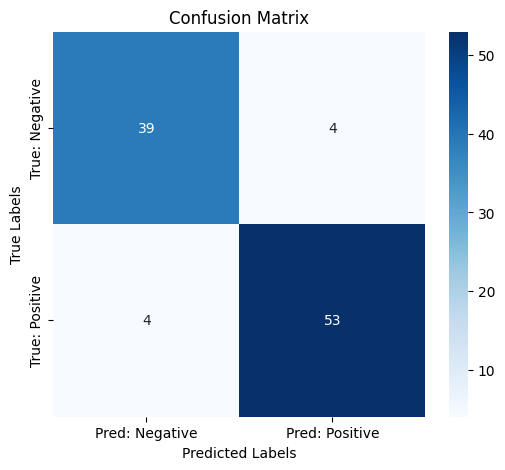

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            # Collecting predictions and true labels for F1, precision, recall, and confusion matrix
            predictions = (outputs > 0.5).float()
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

# Calculate the average test loss
history["test_loss"] = test_loss / len(test_loader)

# Calculate accuracy
history["test_accuracy"] = correct_predictions / total_predictions

# Flatten the list of labels and predictions for F1, precision, recall, and confusion matrix
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

history["test_precision"] = precision
history["test_recall"] = recall
history["test_f1"] = f1
history["test_confusion_matrix"] = conf_matrix

# Print results
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Negative", "Pred: Positive"], yticklabels=["True: Negative", "True: Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# torch.save(model, 'res_3d.pth') 

In [18]:
import torch
import torch.nn as nn
from torchvision.models.video import mc3_18

class VideoMC3CrashPredictor(nn.Module):
    def __init__(self, num_classes=1):
        super(VideoMC3CrashPredictor, self).__init__()
        # Load pretrained MC3 model
        self.mc3 = mc3_18(pretrained=True)
        
        # Replace the classification head
        self.mc3.fc = nn.Sequential(
            nn.Linear(self.mc3.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Binary output for crash prediction
        )

    def forward(self, x):
        """
        x: Video Tensor of shape [B, C, T, H, W]
           B: Batch size
           C: Number of channels (e.g., 3 for RGB)
           T: Number of frames
           H, W: Height and width of each frame
        """
        return self.mc3(x)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    model = VideoMC3CrashPredictor()
    
    # Dummy input: batch of 4 videos, each with 16 frames of size 224x224
    video_input = torch.randn(4, 3, 16, 224, 224)
    
    # Forward pass
    output = model(video_input)
    print("Output shape:", output.shape)  # Expected: [4, 1]


/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MC3_18_Weights.KINETICS400_V1`. You can also use `weights=MC3_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([4, 1])


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir)[:500] if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir)[:500] if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/crash_data/crashed'
non_crash_dir ='/home/baklava/crash_data/nocrashed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Compute lengths for each split
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_length, val_length, test_length])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


In [20]:
# Initialize history dictionary
# Define loss function and optimizer
from tqdm import tqdm
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history = {
    "train_loss": [],
    "val_loss": [],
    "test_loss": 0.0,
    "test_accuracy": 0.0
}
device ='cuda'

# Training and validation loop
num_epochs = 5
model=model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1} - Training") as pbar:
        for video_batch, labels in train_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            
            loss = criterion(outputs, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)
    
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1} - Validation") as pbar:
            for video_batch, labels in val_loader:
                video_batch = video_batch.to(device)
                labels = labels.to(device)
                outputs = model(video_batch).squeeze()
            
            # Reshape outputs to match labels
                outputs = outputs.view_as(labels)
                
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
    
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

history["test_loss"] = test_loss / len(test_loader)
history["test_accuracy"] = correct_predictions / total_predictions
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")


Epoch 1 - Training:   0%|          | 0/175 [00:00<?, ?it/s]

/tmp/ipykernel_2334723/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Epoch 1 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, Batch Loss=0.763]


Epoch 1, Training Loss: 0.6942


Epoch 1 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.29it/s, Batch Loss=0.803]


Epoch 1, Validation Loss: 0.6676


Epoch 2 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, Batch Loss=0.641]


Epoch 2, Training Loss: 0.6591


Epoch 2 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.39it/s, Batch Loss=0.722]


Epoch 2, Validation Loss: 0.6231


Epoch 3 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, Batch Loss=0.544]


Epoch 3, Training Loss: 0.6249


Epoch 3 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.38it/s, Batch Loss=0.624]


Epoch 3, Validation Loss: 0.5755


Epoch 4 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, Batch Loss=0.579]


Epoch 4, Training Loss: 0.5904


Epoch 4 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.39it/s, Batch Loss=0.592]


Epoch 4, Validation Loss: 0.5219


Epoch 5 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, Batch Loss=0.616]


Epoch 5, Training Loss: 0.5550


Epoch 5 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.36it/s, Batch Loss=0.478]


Epoch 5, Validation Loss: 0.4653


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]

Test Loss: 0.4735, Test Accuracy: 97.00%


In [ ]:
# torch.save(model, 'mixed_3d.pth') 

In [22]:
model = torch.load('mixed_3d.pth')

/tmp/ipykernel_2334723/402450674.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mixed_3d.pth')


Testing:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2334723/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Testing: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


Test Loss: 0.4735, Test Accuracy: 97.00%
Test Precision: 0.9783
Test Recall: 0.9574
Test F1 Score: 0.9677
Confusion Matrix:
[[52  1]
 [ 2 45]]


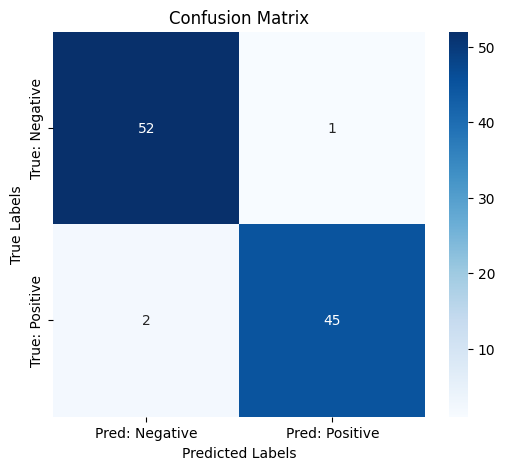

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            # Collecting predictions and true labels for F1, precision, recall, and confusion matrix
            predictions = (outputs > 0.5).float()
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

# Calculate the average test loss
history["test_loss"] = test_loss / len(test_loader)

# Calculate accuracy
history["test_accuracy"] = correct_predictions / total_predictions

# Flatten the list of labels and predictions for F1, precision, recall, and confusion matrix
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

history["test_precision"] = precision
history["test_recall"] = recall
history["test_f1"] = f1
history["test_confusion_matrix"] = conf_matrix

# Print results
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Negative", "Pred: Positive"], yticklabels=["True: Negative", "True: Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [6]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir) if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir) if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/carshe_data_iinf/crrashed/crashed'
non_crash_dir ='/home/baklava/carshe_data_iinf/crrashed/noncahsed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios
# train_ratio = 0.7
# val_ratio = 0.2
test_ratio = 1

# Compute lengths for each split
# total_length = len(dataset)
# train_length = int(train_ratio * total_length)
# val_length = int(val_ratio * total_length)
# test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
test_dataset = dataset

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


In [ ]:

# model=torch.load('res_3d.pth')

/tmp/ipykernel_2334723/946842304.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('res_3d.pth')


In [5]:
model = torch.load('crash_predector_model.pth')

/tmp/ipykernel_2588959/2045320317.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('crash_predector_model.pth')


In [11]:
model.eval()
video_batch,labels=dataset[1]
# print(video_batch)
video_batch = video_batch.to(device)
video_batch=video_batch.unsqueeze(0)
# labels = labels.to(device)

# outputs = model([video_batch]).squeeze()
outputs = model(video_batch).squeeze()
predictions =int((outputs > 0.5))
# outputs = outputs.view_as(labels)
print(predictions,labels)

1 1


/tmp/ipykernel_2588959/1910478030.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


Sequence Label: 1
Frames Shape: torch.Size([3, 16, 224, 224])


/tmp/ipykernel_2588959/1910478030.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


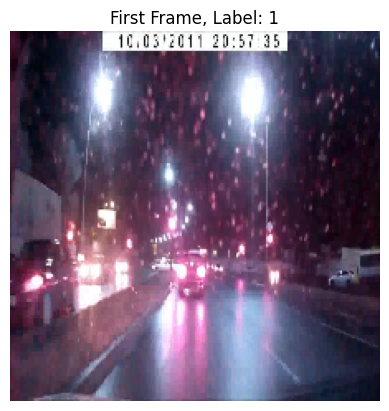

In [12]:
# Get the first item from the dataset
frames, label = dataset[1]

# Print label
print("Sequence Label:", label)  # 0 or 1

# Print the shape of the frames
print("Frames Shape:", frames.shape)  # [C, T, H, W]

# Inspect the first frame in the sequence
first_frame = frames[:, 0, :, :]  # Extract the first frame (shape: [C, H, W])

# Convert the first frame to a numpy array for visualization
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Denormalize the image for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
denormalized_frame = first_frame * std + mean  # Reverse normalization

# Convert to numpy for display
frame_np = denormalized_frame.permute(1, 2, 0).numpy()  # [H, W, C]

# Plot the frame
plt.imshow(frame_np)
plt.title(f"First Frame, Label: {label}")
plt.axis('off')
plt.show()


In [10]:
model.eval()
video_batch,labels=dataset[3]
# print(video_batch)
video_batch = video_batch.to(device)
video_batch=video_batch.unsqueeze(0)
# labels = labels.to(device)

# outputs = model([video_batch]).squeeze()
outputs = model(video_batch).squeeze()
predictions =int((outputs > 0.5))
# outputs = outputs.view_as(labels)
print(predictions,labels)

/tmp/ipykernel_2588959/1910478030.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


0 0


In [9]:
device='cuda'

In [37]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (112, 112)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir) if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir) if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/carshe_data_iinf/crrashed/crashed'
non_crash_dir ='/home/baklava/carshe_data_iinf/crrashed/noncahsed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios

test_ratio = 1
# Compute lengths for each split
# total_length = len(dataset)
# train_length = int(train_ratio * total_length)
# val_length = int(val_ratio * total_length)
# test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
test_dataset = dataset

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


Video saved as output_video.avi


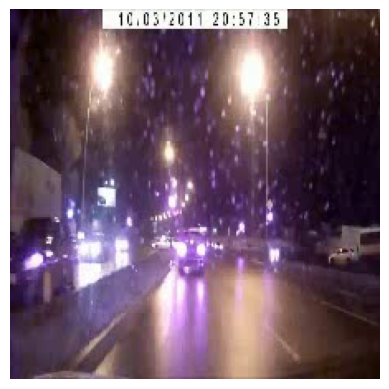

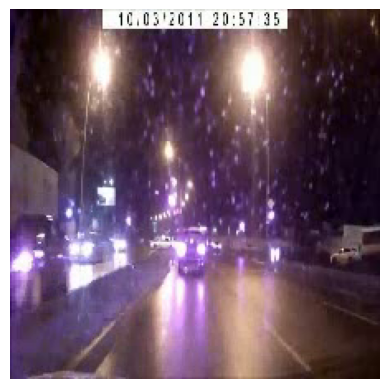

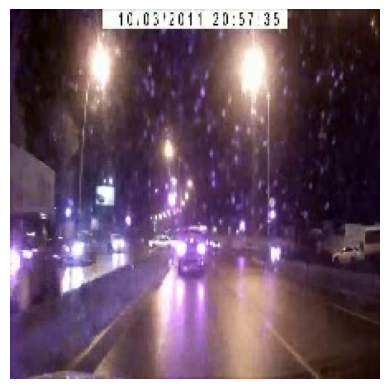

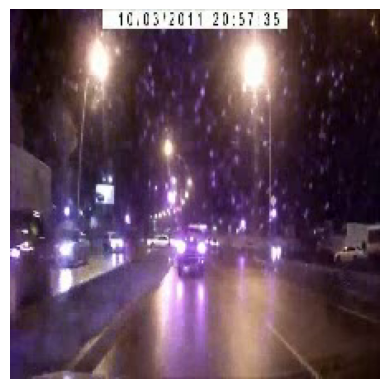

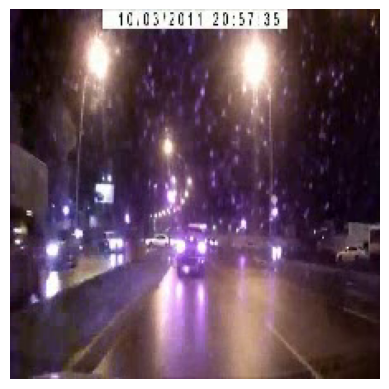

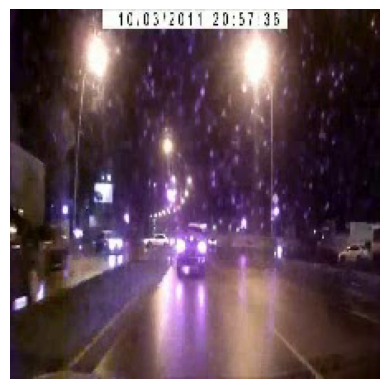

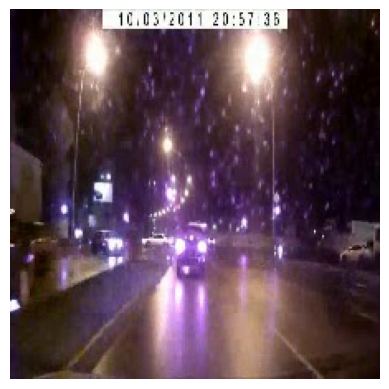

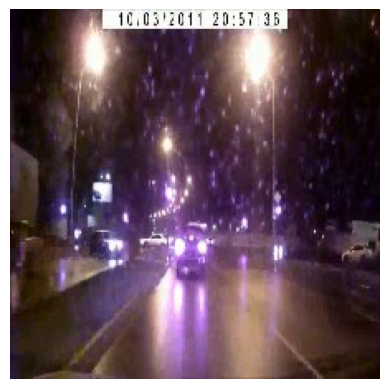

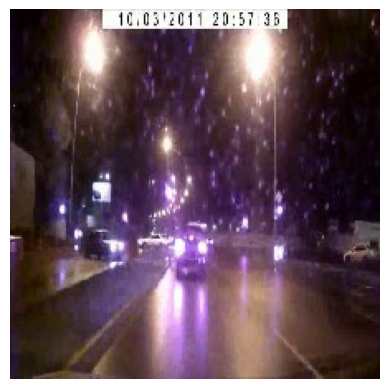

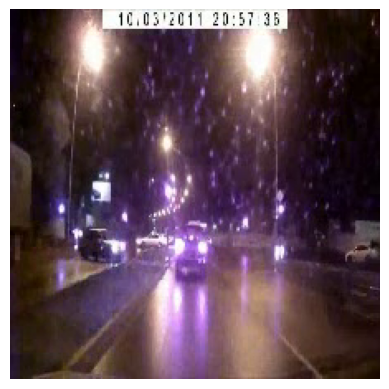

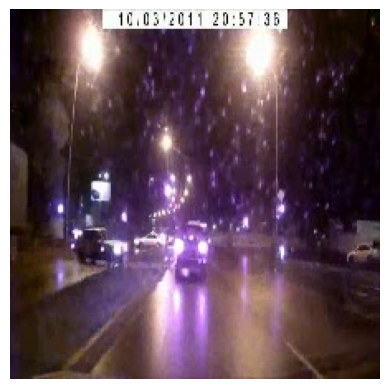

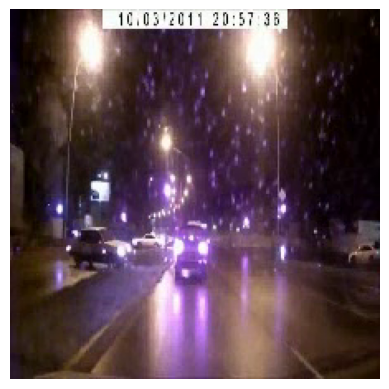

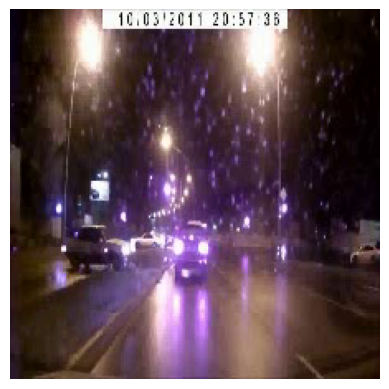

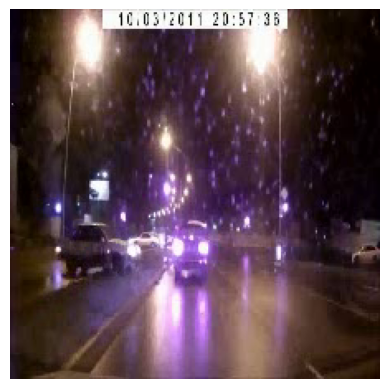

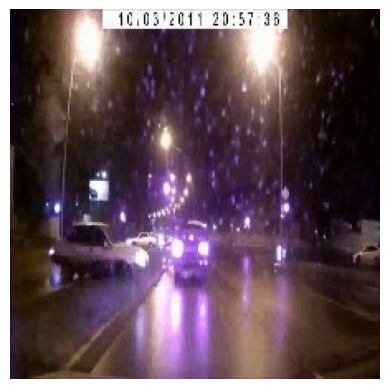

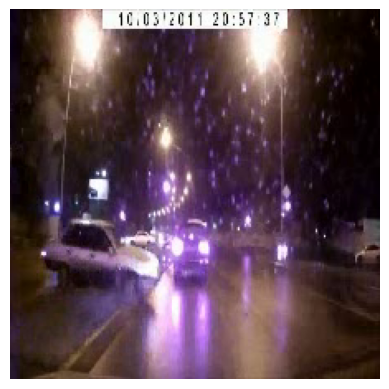

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the frame rate and output video file name
fps = 30  # Frames per second
output_video = 'output_video.avi'

# Get the dimensions of the first frame (assuming all frames have the same size)
frame_height, frame_width = frames.shape[2], frames.shape[3]

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MJPG' or 'MP4V'
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

# Loop through frames from 0 to 15
for i in range(16):
    frame = frames[:, i, :, :]  # Get frame i
    denormalized_frame = frame * std + mean  # Reverse normalization

    # Convert to numpy array and permute to [H, W, C] format
    frame_np = denormalized_frame.permute(1, 2, 0).numpy()  # [H, W, C]

    # Convert to uint8 for OpenCV (values between 0 and 255)
    frame_np = np.clip(frame_np * 255, 0, 255).astype(np.uint8)

    # Write the frame to the video file
    video_writer.write(frame_np)

# Release the VideoWriter object
video_writer.release()

# Confirm the video creation
print(f"Video saved as {output_video}")

# Play the video using matplotlib
cap = cv2.VideoCapture(output_video)

# Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        # Convert frame to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display the frame using matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')  # Hide axes
        plt.draw()
        plt.pause(1 / fps)  # Pause to control frame rate

    # Close the plot window after playback
    plt.close()
    cap.release()


In [38]:
model = torch.load('res_3d.pth')

/tmp/ipykernel_2334723/2551582838.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('res_3d.pth')


Sequence Label: 1
Frames Shape: torch.Size([3, 16, 112, 112])


/tmp/ipykernel_2334723/1176346815.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


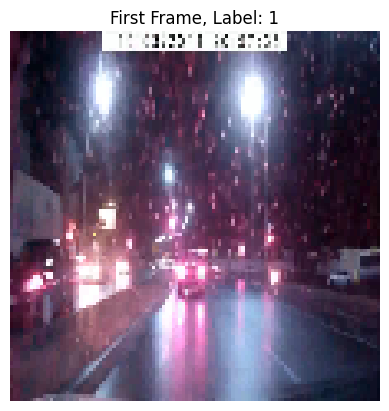

In [52]:
# Get the first item from the dataset
frames, label = dataset[1]

# Print label
print("Sequence Label:", label)  # 0 or 1

# Print the shape of the frames
print("Frames Shape:", frames.shape)  # [C, T, H, W]

# Inspect the first frame in the sequence
first_frame = frames[:, 0, :, :]  # Extract the first frame (shape: [C, H, W])

# Convert the first frame to a numpy array for visualization
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Denormalize the image for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
denormalized_frame = first_frame * std + mean  # Reverse normalization

# Convert to numpy for display
frame_np = denormalized_frame.permute(1, 2, 0).numpy()  # [H, W, C]

# Plot the frame
plt.imshow(frame_np)
plt.title(f"First Frame, Label: {label}")
plt.axis('off')
plt.show()


Video saved as output_video.avi


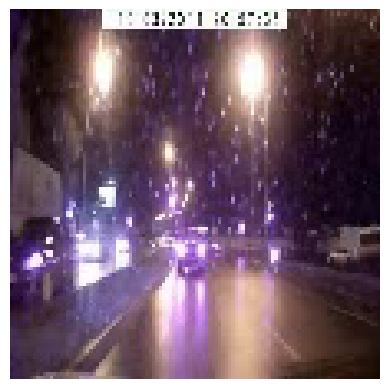

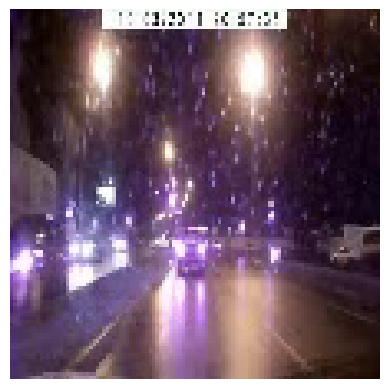

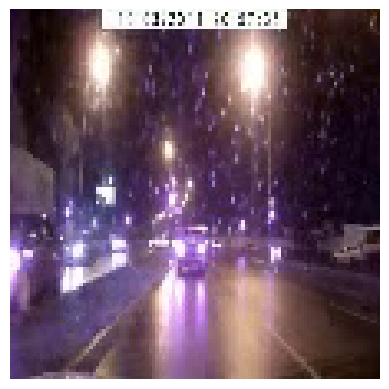

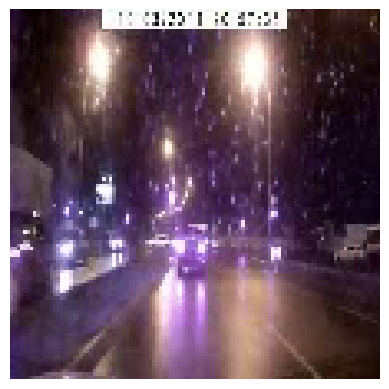

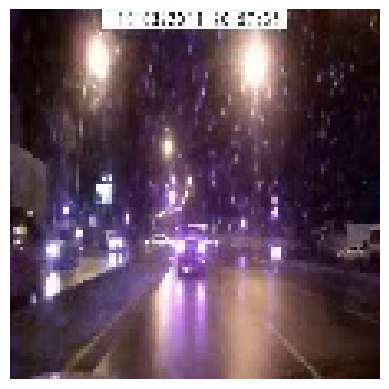

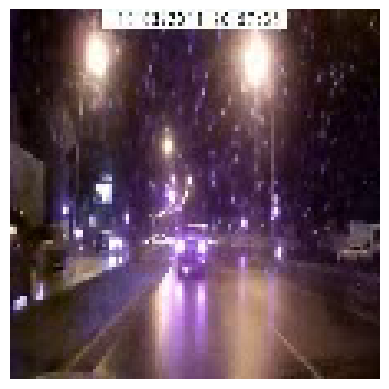

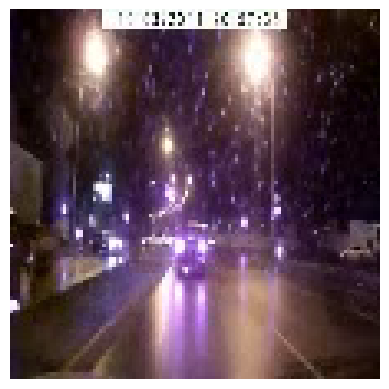

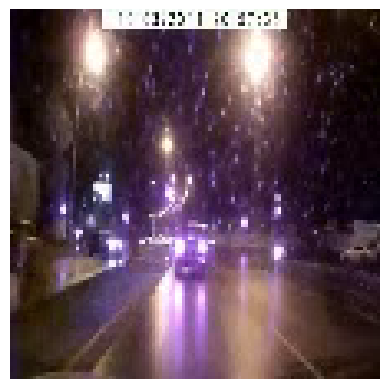

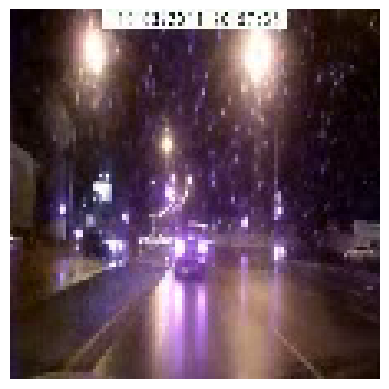

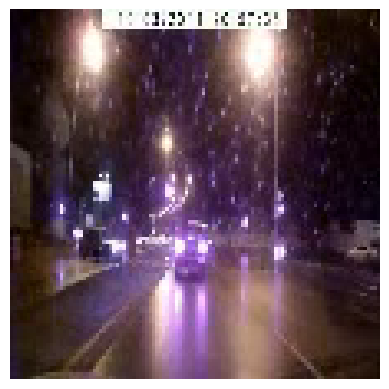

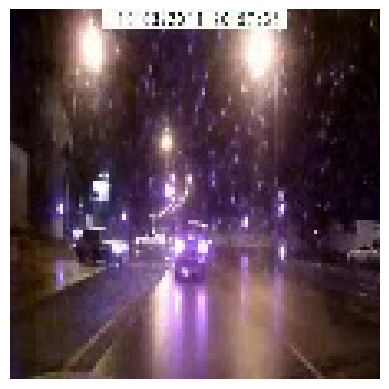

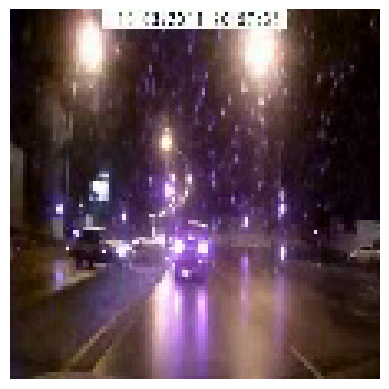

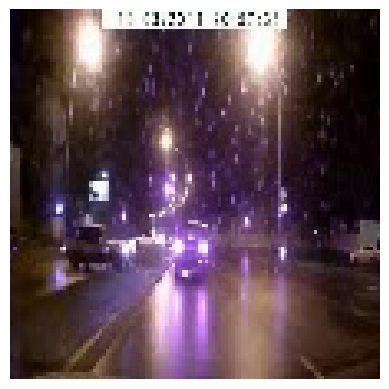

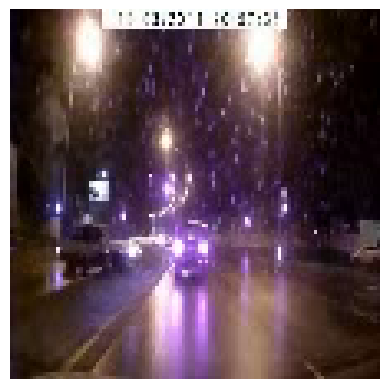

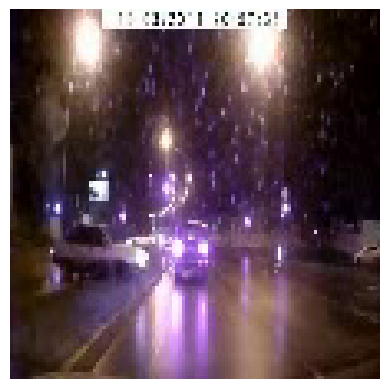

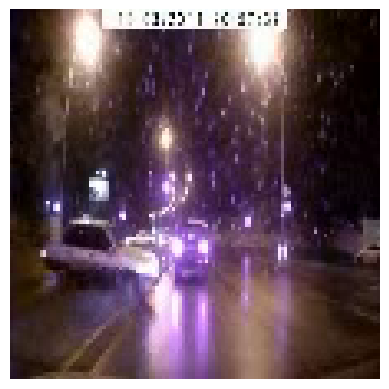

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the frame rate and output video file name
fps = 30  # Frames per second
output_video = 'output_video.avi'

# Get the dimensions of the first frame (assuming all frames have the same size)
frame_height, frame_width = frames.shape[2], frames.shape[3]

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MJPG' or 'MP4V'
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

# Loop through frames from 0 to 15
for i in range(16):
    frame = frames[:, i, :, :]  # Get frame i
    denormalized_frame = frame * std + mean  # Reverse normalization

    # Convert to numpy array and permute to [H, W, C] format
    frame_np = denormalized_frame.permute(1, 2, 0).numpy()  # [H, W, C]

    # Convert to uint8 for OpenCV (values between 0 and 255)
    frame_np = np.clip(frame_np * 255, 0, 255).astype(np.uint8)

    # Write the frame to the video file
    video_writer.write(frame_np)

# Release the VideoWriter object
video_writer.release()

# Confirm the video creation
print(f"Video saved as {output_video}")

# Play the video using matplotlib
cap = cv2.VideoCapture(output_video)

# Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        # Convert frame to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display the frame using matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')  # Hide axes
        plt.draw()
        plt.pause(1 / fps)  # Pause to control frame rate

    # Close the plot window after playback
    plt.close()
    cap.release()


In [51]:
model.eval()
video_batch,labels=dataset[1]
# print(video_batch
video_batch = video_batch.to(device)
video_batch=video_batch.unsqueeze(0)
# labels = labels.to(device)

# outputs = model([video_batch]).squeeze()
outputs = model(video_batch).squeeze()
predictions =int((outputs > 0.5))
# outputs = outputs.view_as(labels)
print(predictions,labels)

0 1


/tmp/ipykernel_2334723/1176346815.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
